In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import tensorflow as tf
import joblib

# Remplacez 'chemin/vers/votre/projet/module' par le chemin absolu réel vers le dossier "module" via la commande pwd
module_path = '/Users/eliotsouthon/Desktop/POC/Code/Modules'  
sys.path.append(module_path)
import ma_bibliotheque 

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [2]:
csv_file_paths=ma_bibliotheque.path_data('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model')
# Affiche la liste des chemins pour vérifier
print("Liste des chemins des fichiers CSV :")
for path in csv_file_paths:
    print(path)

Liste des chemins des fichiers CSV :
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/prediction_250_75.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/w_api.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/Comparaison_realite.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/weather_forecast_3h.csv


## Prediction

In [3]:
# Charger le modèle sauvegardé avec TensorFlow
model = tf.keras.models.load_model('/Users/eliotsouthon/Desktop/POC/POC/model_save/modele_sauvegarde.h5')

2024-11-20 16:17:49.028297: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-20 16:17:49.028335: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-11-20 16:17:49.028348: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-11-20 16:17:49.028377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 16:17:49.028400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# Charger le fichier CSV avec Pandas
data = pd.read_csv('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/prediction_250_75.csv', sep=';',encoding='utf-8')
data.head()

# Récuprère les dates officielles
data_raw = pd.read_csv('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/weather_forecast_3h.csv', sep=',',encoding='utf-8')
data_raw['date'] = pd.to_datetime(data_raw['date'])

In [18]:
# Pour utiliser la meme normalisation
data.insert(0, 'Consommation brute électricité (MW)', 1)
# Charger le scaler sauvegardé
scaler = joblib.load('scaler_minmax.pkl')
# Vous pouvez utiliser le même scaler pour normaliser ces nouvelles données de la même manière
features_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)

# Suppression de la colonne 'Consommation brute électricité (MW)'
data = data.drop(columns=['Consommation brute électricité (MW)'])

In [19]:
# Faire des prédictions avec le modèle
predictions = model.predict(features_scaled)

2024-11-20 16:38:59.861962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step


ValueError: x and y must have same first dimension, but have shapes (120,) and (40, 1)

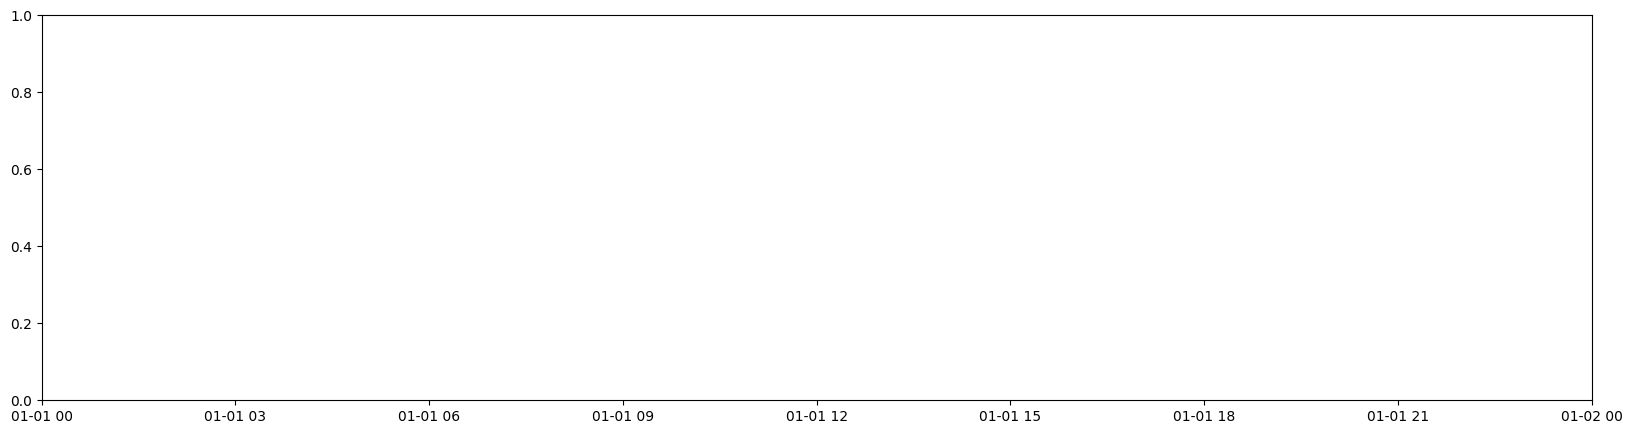

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer le graphique
plt.figure(figsize=(20, 5))
plt.plot(data_raw['date'], predictions, label='Prédiction de consommation normalisée')  # Assurez-vous que 'predictions' correspond à la longueur de 'data_raw['date']'

# Définir le format des dates
plt.xlabel('Temps')
plt.ylabel('Prédictions')
plt.title('Prédictions de consommation sur 5 jours (heure par heure) à partir de prédiction météologique OpenWeatherMap')

# Modifier les ticks de l'axe des x pour afficher toutes les 24 heures + heure toutes les 2h
plt.xticks(rotation=0)  # Ne pas incliner les labels des dates principales

# Définir les ticks principaux (tous les jours)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Un tick toutes les 24h
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format de la date

# Ajouter une deuxième ligne d'abscisse pour l'heure toutes les 2 heures
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Ticks toutes les 2 heures
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure

# Rotation des labels des heures mineures pour une meilleure lisibilité
plt.gca().tick_params(axis='x', which='minor', rotation=45)  # Rotation des labels des heures mineures

# Activer la grille pour les ticks mineurs (heures)
plt.grid(True, which='both')

# Ajouter des lignes de grille rouges et modifier les dates du début de jour
ax = plt.gca()
for date in data_raw['date']:
    if date.hour == 0 and date.minute == 0:  # Si c'est le début d'un nouveau jour
        # Ajouter une ligne verticale rouge
        ax.axvline(x=date, color='red', linestyle='--', lw=2)  # Ajouter une ligne verticale rouge

        # Mettre la date en rouge sur l'axe des x et décaler les dates en dessous
        tick_labels = ax.get_xticklabels()
        for label in tick_labels:
            if label.get_text() == date.strftime('%Y-%m-%d'):
                label.set_color('red')  # Mettre en rouge la date du début de jour
                label.set_position((label.get_position()[0], -0.10))  # Déplacer la date 10 points plus bas

# Ajouter la légende en haut à droite
plt.legend(loc='upper right')
title = plt.gca().get_title()
output_dir = "/Users/eliotsouthon/Desktop/POC/Images"
ma_bibliotheque.save_figure(title, output_dir)

plt.show()